In [ ]:
import pandas as pd
data = pd.read_parquet('/drive2/phatnt/zTrans/data/full_others_code_dataset.parquet')
data

In [2]:
data = data[~data['fileName'].str.contains('pom.xml')]
data = data[~data['fileName'].str.contains('.java')]
data

,id,fromLib,toLib,repoName,repoOwner,repoSplitName,prevCommit,startCommit,endCommit,fileName,startCode,endCode,diff,startCommitChanges,endCommitChanges
2,2,ant:ant,org.apache.ant:ant,bobmcwhirter_drools,bobmcwhirter,drools,b9fb00e7cb51a87ed91030c0322bcd6d702ec386,0504ef4b2349dd7edc4d4991d29f688dc15da939,0504ef4b2349dd7edc4d4991d29f688dc15da939,,tree b9fb00e7cb51a87ed91030c0322bcd6d702ec386:...,tree 0504ef4b2349dd7edc4d4991d29f688dc15da939:...,diff --git a/drools-ant/pom.xml b/drools-ant/p...,+org.apache.ant:ant\n+org.apache.ant:ant-apach...,+org.apache.ant:ant\n+org.apache.ant:ant-apach...
17,17,ant:ant,org.apache.ant:ant,bobmcwhirter_drools,bobmcwhirter,drools,2ba5d35fb486c4a16b5b8b15fc247e8759bfa54f,92384035a8651b675c82689b24837eb8adb81d66,0df25aead759b3b542a685ac21a3a009bcd22fe9,drools-compiler/src/test/resources/org/drools/...,package org.drools;\n\nglobal java.util.List r...,package org.drools;\n\nglobal java.util.List r...,diff --git a/drools-compiler/src/test/resource...,+org.mockito:mockito-all,-org.jmock:jmock\n-org.jmock:jmock-legacy
18,18,ant:ant,org.apache.ant:ant,bobmcwhirter_drools,bobmcwhirter,drools,2ba5d35fb486c4a16b5b8b15fc247e8759bfa54f,92384035a8651b675c82689b24837eb8adb81d66,0df25aead759b3b542a685ac21a3a009bcd22fe9,drools-compiler/src/test/resources/org/drools/...,#created on: 25/03/2006\npackage org.benchmark...,#created on: 25/03/2006\npackage org.benchmark...,diff --git a/drools-compiler/src/test/resource...,+org.mockito:mockito-all,-org.jmock:jmock\n-org.jmock:jmock-legacy
138,138,ant:ant,org.apache.ant:ant,bobmcwhirter_drools,bobmcwhirter,drools,2ba5d35fb486c4a16b5b8b15fc247e8759bfa54f,92384035a8651b675c82689b24837eb8adb81d66,0df25aead759b3b542a685ac21a3a009bcd22fe9,drools-core/src/test/resources/org/drools/rete...,,"TestCase ""Accumulate Node assert/retract test ...",diff --git a/drools-core/src/test/resources/or...,+org.mockito:mockito-all,-org.jmock:jmock\n-org.jmock:jmock-legacy
139,139,ant:ant,org.apache.ant:ant,bobmcwhirter_drools,bobmcwhirter,drools,2ba5d35fb486c4a16b5b8b15fc247e8759bfa54f,92384035a8651b675c82689b24837eb8adb81d66,0df25aead759b3b542a685ac21a3a009bcd22fe9,drools-core/src/test/resources/org/drools/rete...,,"TestCase ""Accumulate Node modify test case""\n\...",diff --git a/drools-core/src/test/resources/or...,+org.mockito:mockito-all,-org.jmock:jmock\n-org.jmock:jmock-legacy
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118551,118551,saxon:saxon,net.sf.saxon:Saxon-HE,sebastiangraf_treetank,sebastiangraf,treetank,2923f463e0b15eaaec5dba26f86b65a8cd78a8ff,112da91b019e7e0e7c4071a1bfd383d976c97d75,112da91b019e7e0e7c4071a1bfd383d976c97d75,,tree 2923f463e0b15eaaec5dba26f86b65a8cd78a8ff:...,tree 112da91b019e7e0e7c4071a1bfd383d976c97d75:...,diff --git a/coremodules/commons/pom.xml b/cor...,+net.sf.saxon:Saxon-HE\n-saxon:saxon,+net.sf.saxon:Saxon-HE\n-saxon:saxon
118554,118554,velocity:velocity,org.apache.velocity:velocity,mojohaus_webstart,mojohaus,webstart,9a6eaca8aab2aba2c7b8dafb638ec9cca14716b0,e6d0944e489b7849c31957b2b41ca91044aeba65,e6d0944e489b7849c31957b2b41ca91044aeba65,,tree 9a6eaca8aab2aba2c7b8dafb638ec9cca14716b0:...,tree e6d0944e489b7849c31957b2b41ca91044aeba65:...,diff --git a/pom.xml b/pom.xml\nindex 314b6da....,+org.apache.velocity:velocity\n-velocity:velocity,+org.apache.velocity:velocity\n-velocity:velocity
118560,118560,xalan:xalan,net.sourceforge.saxon:saxon,epimorphics_elda,epimorphics,elda,64845b433d6b02eae40c8fcf28161114cdd1a43a,e07982e05c1d9900aa91c87f28ec7bd0ba0a8f0f,e07982e05c1d9900aa91c87f28ec7bd0ba0a8f0f,,tree 64845b433d6b02eae40c8fcf28161114cdd1a43a:...,tree e07982e05c1d9900aa91c87f28ec7bd0ba0a8f0f:...,diff --git a/elda-bundled/pom.xml b/elda-bundl...,+net.sourceforge.saxon:saxon\n+net.sf.saxon:Sa...,+net.sourceforge.saxon:saxon\n+net.sf.saxon:Sa...
118562,118562,xstream:xstream,com.thoughtworks.xstream:xstream,gooddata_GoodData-CL,gooddata,GoodData-CL,1822397e35e12172aeaf98d15c4f12b511678f01,755e83e7940546c7742f4ed03d4435f00a68017c,755e83e79405

In [3]:
def count_file_changes(diff):
    new_file_mode = 1 if 'new file mode' in diff else 0
    deleted_file_mode = 1 if 'deleted file mode' in diff else 0
    return new_file_mode,deleted_file_mode
data[['new_file_mode','delete_file_mode']] = data['diff'].apply(lambda x: pd.Series(count_file_changes(x)))


In [4]:
print(len(data['fileName'].unique()))
print(data['new_file_mode'].sum())
print(data['delete_file_mode'].sum())

43611
20659
15452


In [5]:
print(data[data['startCode'] == ''].iloc[1])

id                                                                  139
fromLib                                                         ant:ant
toLib                                                org.apache.ant:ant
repoName                                            bobmcwhirter_drools
repoOwner                                                  bobmcwhirter
repoSplitName                                                    drools
prevCommit                     2ba5d35fb486c4a16b5b8b15fc247e8759bfa54f
startCommit                    92384035a8651b675c82689b24837eb8adb81d66
endCommit                      0df25aead759b3b542a685ac21a3a009bcd22fe9
fileName              drools-core/src/test/resources/org/drools/rete...
startCode                                                              
endCode               TestCase "Accumulate Node modify test case"\n\...
diff                  diff --git a/drools-core/src/test/resources/or...
startCommitChanges                             +org.mockito:mock

In [10]:
data_code_change = data[(data['new_file_mode'] == 0) & (data['delete_file_mode'] == 0)]
data_code_change

,id,fromLib,toLib,repoName,repoOwner,repoSplitName,prevCommit,startCommit,endCommit,fileName,startCode,endCode,diff,startCommitChanges,endCommitChanges,new_file_mode,delete_file_mode
2,2,ant:ant,org.apache.ant:ant,bobmcwhirter_drools,bobmcwhirter,drools,b9fb00e7cb51a87ed91030c0322bcd6d702ec386,0504ef4b2349dd7edc4d4991d29f688dc15da939,0504ef4b2349dd7edc4d4991d29f688dc15da939,,tree b9fb00e7cb51a87ed91030c0322bcd6d702ec386:...,tree 0504ef4b2349dd7edc4d4991d29f688dc15da939:...,diff --git a/drools-ant/pom.xml b/drools-ant/p...,+org.apache.ant:ant\n+org.apache.ant:ant-apach...,+org.apache.ant:ant\n+org.apache.ant:ant-apach...,0,0
17,17,ant:ant,org.apache.ant:ant,bobmcwhirter_drools,bobmcwhirter,drools,2ba5d35fb486c4a16b5b8b15fc247e8759bfa54f,92384035a8651b675c82689b24837eb8adb81d66,0df25aead759b3b542a685ac21a3a009bcd22fe9,drools-compiler/src/test/resources/org/drools/...,package org.drools;\n\nglobal java.util.List r...,package org.drools;\n\nglobal java.util.List r...,diff --git a/drools-compiler/src/test/resource...,+org.mockito:mockito-all,-org.jmock:jmock\n-org.jmock:jmock-legacy,0,0
18,18,ant:ant,org.apache.ant:ant,bobmcwhirter_drools,bobmcwhirter,drools,2ba5d35fb486c4a16b5b8b15fc247e8759bfa54f,92384035a8651b675c82689b24837eb8adb81d66,0df25aead759b3b542a685ac21a3a009bcd22fe9,drools-compiler/src/test/resources/org/drools/...,#created on: 25/03/2006\npackage org.benchmark...,#created on: 25/03/2006\npackage org.benchmark...,diff --git a/drools-compiler/src/test/resource...,+org.mockito:mockito-all,-org.jmock:jmock\n-org.jmock:jmock-legacy,0,0
169,169,ant:ant,org.apache.ant:ant,bobmcwhirter_drools,bobmcwhirter,drools,1092e4ffa4ba0eb8bb936b2edc3ebc51b135cfc0,6eac86a7222c66a526855b0b129338b96e48e08e,6eac86a7222c66a526855b0b129338b96e48e08e,drools-ant/.classpath,"<?xml version=""1.0"" encoding=""UTF-8""?>\n<class...","<classpath>\n <classpathentry kind=""src"" path...",diff --git a/drools-ant/.classpath b/drools-an...,+com.thoughtworks.xstream:xstream\n-xstream:xs...,+com.thoughtworks.xstream:xstream\n-xstream:xs...,0,0
170,170,ant:ant,org.apache.ant:ant,bobmcwhirter_drools,bobmcwhirter,drools,1092e4ffa4ba0eb8bb936b2edc3ebc51b135cfc0,6eac86a7222c66a526855b0b129338b96e48e08e,6eac86a7222c66a526855b0b129338b96e48e08e,drools-ant/.project,<projectDescription>\n <name>drools-ant</name...,<projectDescription>\n <name>drools-ant</name...,diff --git a/drools-ant/.project b/drools-ant/...,+com.thoughtworks.xstream:xstream\n-xstream:xs...,+com.thoughtworks.xstream:xstream\n-xstream:xs...,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118551,118551,saxon:saxon,net.sf.saxon:Saxon-HE,sebastiangraf_treetank,sebastiangraf,treetank,2923f463e0b15eaaec5dba26f86b65a8cd78a8ff,112da91b019e7e0e7c4071a1bfd383d976c97d75,112da91b019e7e0e7c4071a1bfd383d976c97d75,,tree 2923f463e0b15eaaec5dba26f86b65a8cd78a8ff:...,tree 112da91b019e7e0e7c4071a1bfd383d976c97d75:...,diff --git a/coremodules/commons/pom.xml b/cor...,+net.sf.saxon:Saxon-HE\n-saxon:saxon,+net.sf.saxon:Saxon-HE\n-saxon:saxon,0,0
118554,118554,velocity:velocity,org.apache.velocity:velocity,mojohaus_webstart,mojohaus,webstart,9a6eaca8aab2aba2c7b8dafb638ec9cca14716b0,e6d0944e489b7849c31957b2b41ca91044aeba65,e6d0944e489b7849c31957b2b41ca91044aeba65,,tree 9a6eaca8aab2aba2c7b8dafb638ec9cca14716b0:...,tree e6d0944e489b7849c31957b2b41ca91044aeba65:...,diff --git a/pom.xml b/pom.xml\nindex 314b6da....,+org.apache.velocity:velocity\n-velocity:velocity,+org.apache.velocity:velocity\n-velocity:velocity,0,0
118560,118560,xalan:xalan,net.sourceforge.saxon:saxon,epimorphics_elda,epimorphics,elda,64845b433d6b02eae40c8fcf28161114cdd1a43a,e07982e05c1d9900aa91c87f28ec7bd0ba0a8f0f,e07982e05c1d9900aa91c87f28ec7bd0ba0a8f0f,,tree 64845b433d6b02eae40c8fcf28161114cdd1a43a:...,tree e07982e05c1d9900aa91c87f28ec7bd0ba0a8f0f:...,diff --git a/elda-bundled/pom.xml b/elda-bundl...,+net.sourceforge.saxon:saxon\n+net.sf.saxon:Sa...,+net.sourceforge.saxon:saxon\n+net.sf.saxon:Sa...,0,0
118562,118562,xstream:

In [6]:
import pandas as pd
data = pd.read_parquet('/drive2/phatnt/zTrans/data/no_comment_dataset.parquet')
data

,id,fromLib,toLib,repoName,repoOwner,repoSplitName,prevCommit,startCommit,endCommit,fileName,...,endCommitChanges,startCode_cleaned,endCode_cleaned,diff_cleaned,total_added,total_removed,total_position,detailed_changes,lib_percentage,annotation_change
0,3,ant:ant,org.apache.ant:ant,bobmcwhirter_drools,bobmcwhirter,drools,2ba5d35fb486c4a16b5b8b15fc247e8759bfa54f,92384035a8651b675c82689b24837eb8adb81d66,0df25aead759b3b542a685ac21a3a009bcd22fe9,drools-compiler/src/main/java/org/drools/rule/...,...,-org.jmock:jmock\n-org.jmock:jmock-legacy,package org.drools.rule.builder.dialect.java;\...,package org.drools.rule.builder.dialect.java;\...,"--- \n+++ \n@@ -178,7 +178,6 @@\n cons...",1,2,3,"[{'added_count': 0, 'lib_changes': 0, 'line_ch...",0.000000,0.000000
1,4,ant:ant,org.apache.ant:ant,bobmcwhirter_drools,bobmcwhirter,drools,2ba5d35fb486c4a16b5b8b15fc247e8759bfa54f,92384035a8651b675c82689b24837eb8adb81d66,0df25aead759b3b542a685ac21a3a009bcd22fe9,drools-compiler/src/test/java/org/drools/guvno...,...,-org.jmock:jmock\n-org.jmock:jmock-legacy,package org.drools.guvnor.server.util;\nimport...,package org.drools.guvnor.server.util;\nimport...,"--- \n+++ \n@@ -3,11 +3,9 @@\n import org.droo...",13,18,3,"[{'added_count': 1, 'lib_changes': 3, 'line_ch...",0.096774,0.000000
4,7,ant:ant,org.apache.ant:ant,bobmcwhirter_drools,bobmcwhirter,drools,2ba5d35fb486c4a16b5b8b15fc247e8759bfa54f,92384035a8651b675c82689b24837eb8adb81d66,0df25aead759b3b542a685ac21a3a009bcd22fe9,drools-compiler/src/test/java/org/drools/integ...,...,-org.jmock:jmock\n-org.jmock:jmock-legacy,package org.drools.integrationtests;\nimport j...,package org.drools.integrationtests;\nimport j...,"--- \n+++ \n@@ -436,9 +436,8 @@\n ...",5,8,5,"[{'added_count': 1, 'lib_changes': 0, 'line_ch...",0.000000,0.000000
6,9,ant:ant,org.apache.ant:ant,bobmcwhirter_drools,bobmcwhirter,drools,2ba5d35fb486c4a16b5b8b15fc247e8759bfa54f,92384035a8651b675c82689b24837eb8adb81d66,0df25aead759b3b542a685ac21a3a009bcd22fe9,drools-compiler/src/test/java/org/drools/integ...,...,-org.jmock:jmock\n-org.jmock:jmock-legacy,package org.drools.integrationtests;\nimport j...,package org.drools.integrationtests;\nimport s...,"--- \n+++ \n@@ -1,4 +1,8 @@\n package org.droo...",16,28,12,"[{'added_count': 4, 'lib_changes': 4, 'line_ch...",0.227273,0.000000
7,10,ant:ant,org.apache.ant:ant,bobmcwhirter_drools,bobmcwhirter,drools,2ba5d35fb486c4a16b5b8b15fc247e8759bfa54f,92384035a8651b675c82689b24837eb8adb81d66,0df25aead759b3b542a685ac21a3a009bcd22fe9,drools-compiler/src/test/java/org/drools/integ...,...,-org.jmock:jmock\n-org.jmock:jmock-legacy,package org.drools.integrationtests;\nimport j...,package org.drools.integrationtests;\nimport j...,"--- \n+++ \n@@ -110,6 +110,7 @@\n }\n ...",1,0,2,"[{'added_count': 1, 'lib_changes': 0, 'line_ch...",0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57638,118538,ru.yandex.qatools.properties:properties-loader,ru.qatools.commons:properties,yandex-qatools_hamcrest-pojo-matcher-generator,yandex-qatools,hamcrest-pojo-matcher-generator,13ac1e25cc715b6855890070099a3cdbea36cf56,cc7a474d3ea53164d28b4a1b23c25989982e7d03,cc7a474d3ea53164d28b4a1b23c25989982e7d03,feature-matcher-generator/src/test/java/ru/yan...,...,+ru.qatools.commons:properties\n-ru.yandex.qat...,package ru.yandex.qatools.processors.matcher.g...,package ru.yandex.qatools.processors.matcher.g...,"--- \n+++ \n@@ -3,7 +3,6 @@\n import org.junit...",1,9,3,"[{'added_count': 0, 'lib_changes': 1, 'line_ch...",0.200000,0.100000
57639,118539,ru.yandex.qatools.properties:properties-loader,ru.qatools.commons:properties,yandex-qatools_hamcrest-pojo-matcher-generator,yandex-qatools,hamcrest-pojo-matcher-generator,13ac1e25cc715b6855890070099a3cdbea36cf56,cc7a474d3ea53164d28b4a1b23c25989982e7d03,cc7a474d3ea53164d28b4a1b23c25989982e7d03,feature-matcher-generator/src/test/java/ru/yan...,...,+ru.qatools.commons:properties\n-ru.yandex.qat...,package ru.yandex.qatools.processors.match

In [7]:
data_target = data[ (data['total_added'] < 10) & (data['total_removed'] < 10)] 
data_target['startCode_lines'] = data_target['startCode_cleaned'].apply(lambda x: x.count('\n') + 1)
data_target['endCode_lines'] = data_target['endCode_cleaned'].apply(lambda x: x.count('\n') + 1)
data_target['total_line_changes'] = data_target['total_added'] + data_target['total_removed']
data_target['percentage_total_changes'] = (data_target['total_line_changes'] / data_target['startCode_lines']) * 100
data_target

/tmp/ipykernel_2886130/3529979253.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_target['startCode_lines'] = data_target['startCode_cleaned'].apply(lambda x: x.count('\n') + 1)
/tmp/ipykernel_2886130/3529979253.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_target['endCode_lines'] = data_target['endCode_cleaned'].apply(lambda x: x.count('\n') + 1)
/tmp/ipykernel_2886130/3529979253.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

,id,fromLib,toLib,repoName,repoOwner,repoSplitName,prevCommit,startCommit,endCommit,fileName,...,total_added,total_removed,total_position,detailed_changes,lib_percentage,annotation_change,startCode_lines,endCode_lines,total_line_changes,percentage_total_changes
0,3,ant:ant,org.apache.ant:ant,bobmcwhirter_drools,bobmcwhirter,drools,2ba5d35fb486c4a16b5b8b15fc247e8759bfa54f,92384035a8651b675c82689b24837eb8adb81d66,0df25aead759b3b542a685ac21a3a009bcd22fe9,drools-compiler/src/main/java/org/drools/rule/...,...,1,2,3,"[{'added_count': 0, 'lib_changes': 0, 'line_ch...",0.000000,0.000000,218,217,3,1.376147
4,7,ant:ant,org.apache.ant:ant,bobmcwhirter_drools,bobmcwhirter,drools,2ba5d35fb486c4a16b5b8b15fc247e8759bfa54f,92384035a8651b675c82689b24837eb8adb81d66,0df25aead759b3b542a685ac21a3a009bcd22fe9,drools-compiler/src/test/java/org/drools/integ...,...,5,8,5,"[{'added_count': 1, 'lib_changes': 0, 'line_ch...",0.000000,0.000000,960,957,13,1.354167
7,10,ant:ant,org.apache.ant:ant,bobmcwhirter_drools,bobmcwhirter,drools,2ba5d35fb486c4a16b5b8b15fc247e8759bfa54f,92384035a8651b675c82689b24837eb8adb81d66,0df25aead759b3b542a685ac21a3a009bcd22fe9,drools-compiler/src/test/java/org/drools/integ...,...,1,0,2,"[{'added_count': 1, 'lib_changes': 0, 'line_ch...",0.000000,0.000000,118,119,1,0.847458
8,11,ant:ant,org.apache.ant:ant,bobmcwhirter_drools,bobmcwhirter,drools,2ba5d35fb486c4a16b5b8b15fc247e8759bfa54f,92384035a8651b675c82689b24837eb8adb81d66,0df25aead759b3b542a685ac21a3a009bcd22fe9,drools-compiler/src/test/java/org/drools/integ...,...,1,2,2,"[{'added_count': 1, 'lib_changes': 0, 'line_ch...",0.000000,0.000000,643,642,3,0.466563
10,13,ant:ant,org.apache.ant:ant,bobmcwhirter_drools,bobmcwhirter,drools,2ba5d35fb486c4a16b5b8b15fc247e8759bfa54f,92384035a8651b675c82689b24837eb8adb81d66,0df25aead759b3b542a685ac21a3a009bcd22fe9,drools-compiler/src/test/java/org/drools/reteo...,...,4,0,2,"[{'added_count': 4, 'lib_changes': 0, 'line_ch...",0.000000,0.000000,35,39,4,11.428571
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57633,118533,ru.yandex.qatools.properties:properties-loader,ru.qatools.commons:properties,yandex-qatools_hamcrest-pojo-matcher-generator,yandex-qatools,hamcrest-pojo-matcher-generator,13ac1e25cc715b6855890070099a3cdbea36cf56,cc7a474d3ea53164d28b4a1b23c25989982e7d03,cc7a474d3ea53164d28b4a1b23c25989982e7d03,feature-matcher-generator/src/main/java/ru/yan...,...,4,9,3,"[{'added_count': 4, 'lib_changes': 9, 'line_ch...",0.692308,0.153846,29,24,13,44.827586
57638,118538,ru.yandex.qatools.properties:properties-loader,ru.qatools.commons:properties,yandex-qatools_hamcrest-pojo-matcher-generator,yandex-qatools,hamcrest-pojo-matcher-generator,13ac1e25cc715b6855890070099a3cdbea36cf56,cc7a474d3ea53164d28b4a1b23c25989982e7d03,cc7a474d3ea53164d28b4a1b23c25989982e7d03,feature-matcher-generator/src/test/java/ru/yan...,...,1,9,3,"[{'added_count': 0, 'lib_changes': 1, 'line_ch...",0.200000,0.100000,34,26,10,29.411765
57639,118539,ru.yandex.qatools.properties:properties-loader,ru.qatools.commons:properties,yandex-qatools_hamcrest-pojo-matcher-generator,yandex-qatools,hamcrest-pojo-matcher-generator,13ac1e25cc715b6855890070099a3cdbea36cf56,cc7a474d3ea53164d28b4a1b23c25989982e7d03,cc7a474d3ea53164d28b4a1b23c25989982e7d03,feature-matcher-generator/src/test/java/ru/yan...,...,7,7,4,"[{'added_count': 2, 'lib_changes': 4, 'line_ch...",0.285714,0.000000,75,75,14,18.666667
57640,118540,ru.yandex.qatools.properties:properties-loader,ru.qatools.commons:properties,yandex-qatools_hamcrest-pojo-matcher-generator,yandex-qatools,hamcrest-pojo-matcher-generator,13ac1e25cc715b6855890070099a3cdbea36cf56,cc7a474d3ea53164d28b4a1b23c25989982e7d03,cc7a474d3ea53164d28b4a1b23c25989982e7d03,feature-matcher-generator/src/test/java/ru/yan...,...,7,7,6,"[{'added_count': 0, 'lib_changes': 1, 'line_ch...",0.285714,0.000000,47,47,14,29.787234


In [8]:
data_target['startCode_lines'].describe()

count    11822.000000
mean       109.241837
std        184.290179
min          1.000000
25%         27.000000
50%         57.000000
75%        120.000000
max       4497.000000
Name: startCode_lines, dtype: float64

Hệ số tương quan giữa startCode_lines và total_line_changes: -0.0036032176081349523


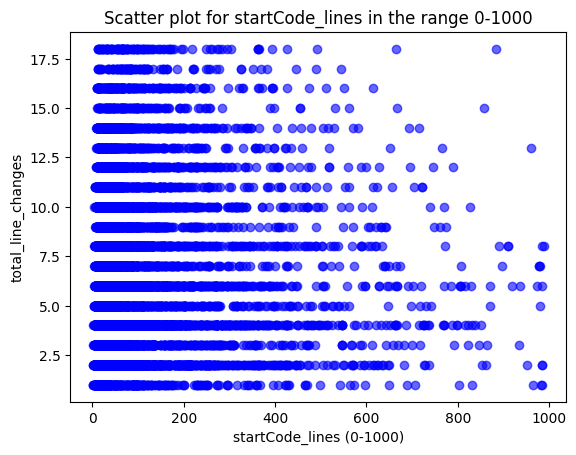

In [3]:
correlation = data_target['startCode_lines'].corr(data_target['total_line_changes'])
print("Hệ số tương quan giữa startCode_lines và total_line_changes:", correlation)
import matplotlib.pyplot as plt
filtered_data = data_target[(data_target['startCode_lines'] >= 0) & (data_target['startCode_lines'] <= 1000)]

# Vẽ biểu đồ scatter với dữ liệu đã lọc
plt.scatter(filtered_data['startCode_lines'], filtered_data['total_line_changes'], color='blue', alpha=0.6)
plt.xlabel("startCode_lines (0-1000)")
plt.ylabel("total_line_changes")
plt.title("Scatter plot for startCode_lines in the range 0-1000")
plt.show()

count    11822.000000
mean        17.305377
std         21.108081
min          0.022237
25%          4.081633
50%         10.000000
75%         22.950820
max        333.333333
Name: percentage_total_changes, dtype: float64


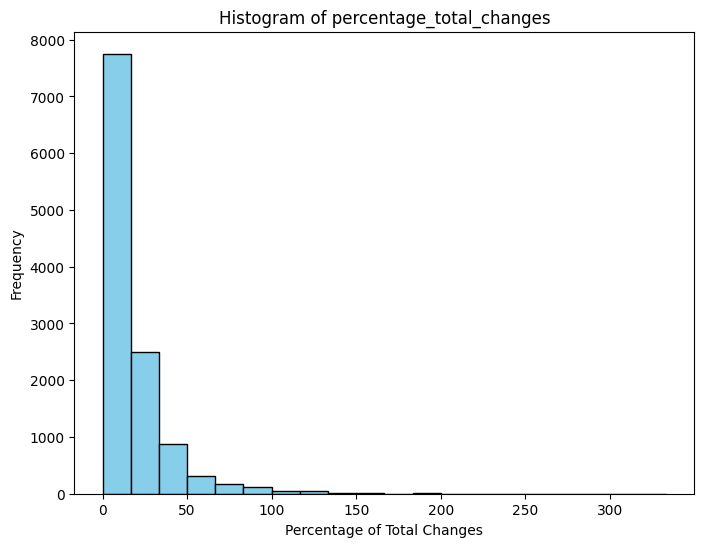

In [4]:
print(data_target['percentage_total_changes'].describe())
plt.figure(figsize=(8, 6))
plt.hist(data_target['percentage_total_changes'], bins=20, color='skyblue', edgecolor='black')
plt.xlabel("Percentage of Total Changes")
plt.ylabel("Frequency")
plt.title("Histogram of percentage_total_changes")
plt.show()
# print(data_target[data_target['percentage_total_changes'] >100].iloc[1])
# print(data_target[data_target['percentage_total_changes'] >100].iloc[1]['startCode'])
# print('----->')
# print(data_target[data_target['percentage_total_changes'] >100].iloc[1]['endCode'])
# print('----->')
# print(data_target[data_target['percentage_total_changes'] >100].iloc[1]['diff'])


In [4]:
df_sorted = data_target.sort_values(by=['startCode_lines', 'endCode_lines'], ascending=[False, True])
df_sorted

,id,fromLib,toLib,repoName,repoOwner,repoSplitName,prevCommit,startCommit,endCommit,fileName,...,startCommitChanges,endCommitChanges,total_added,total_removed,total_position,detailed_changes,lib_percentage,annotation_change,startCode_lines,endCode_lines
51715,95443,org.json:json,com.fasterxml.jackson.core:jackson-core,Esri_geometry-api-java,Esri,geometry-api-java,dcbabdc71e20dfb1b3dd19374fb49e076ed61658,9bedde397f2f61675bc687b95875893aa7cd7f2f,9bedde397f2f61675bc687b95875893aa7cd7f2f,src/test/java/com/esri/core/geometry/TestRelat...,...,+com.fasterxml.jackson.core:jackson-core\n-org...,+com.fasterxml.jackson.core:jackson-core\n-org...,1,2,3,"[{'added_count': 0, 'lib_changes': 1, 'line_ch...",0.333333,0.0,5509,5508
37976,75980,jdom:jdom,org.jdom:jdom2,calibre2opds_calibre2opds,calibre2opds,calibre2opds,1b6bfec9e2f5657edd0dad4652024633856d983f,64c1e1b4ba2287b1a9e906bd260bf7940b094706,64c1e1b4ba2287b1a9e906bd260bf7940b094706,OpdsOutput/src/main/java/com/gmail/dpierron/ca...,...,+org.jdom:jdom2\n-jdom:jdom,+org.jdom:jdom2\n-jdom:jdom,1,0,2,"[{'added_count': 1, 'lib_changes': 0, 'line_ch...",0.000000,0.0,5221,5222
32922,67539,commons-io:commons-io,org.apache.commons:commons-io,mock-server_mockserver,mock-server,mockserver,ec6e389cde20150429e22b8e9f8a60f57c8a24c3,bd9bad5d1ec2bd572713d0e79d4d206ea11ae57e,bd9bad5d1ec2bd572713d0e79d4d206ea11ae57e,mockserver-integration-testing/src/main/java/o...,...,+org.apache.commons:commons-io\n-commons-io:co...,+org.apache.commons:commons-io\n-commons-io:co...,4,8,5,"[{'added_count': 1, 'lib_changes': 0, 'line_ch...",0.000000,0.0,4220,4216
37947,75907,jdom:jdom,org.jdom:jdom,agilebirds_openflexo,agilebirds,openflexo,206a21fc792ce7e8a19de64898da240da6e3e469,8502e8df5fe8f4bd5d7435b9772d1af70b30553b,8502e8df5fe8f4bd5d7435b9772d1af70b30553b,flexodesktop/model/flexofoundation/src/main/ja...,...,+org.jdom:jdom\n-jdom:jdom,+org.jdom:jdom\n-jdom:jdom,5,0,2,"[{'added_count': 5, 'lib_changes': 0, 'line_ch...",0.000000,0.0,4160,4165
29820,57518,commons-collections:commons-collections,org.apache.commons:commons-collections4,apache_directory-server,apache,directory-server,310007cc1c7eb5415f93bed67d5553bc70980820,28b852e8d9bd762b337da51fee46bc2a6d3ba05a,28b852e8d9bd762b337da51fee46bc2a6d3ba05a,xdbm-partition/src/main/java/org/apache/direct...,...,+com.github.ben-manes.caffeine:caffeine\n+java...,+com.github.ben-manes.caffeine:caffeine\n+java...,2,3,3,"[{'added_count': 1, 'lib_changes': 3, 'line_ch...",0.600000,0.0,3721,3720
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38398,76466,jline:jline,org.sonatype.jline:jline,Fabric3_fabric3-core,Fabric3,fabric3-core,2d7854b4b030450e74acdeacd2aad54e2eb225ab,1f237b9b09e5239f4304796c8ad08e33fdf7d598,1f237b9b09e5239f4304796c8ad08e33fdf7d598,extension/binding/fabric3-binding-rs-jersey/sr...,...,+com.fasterxml.jackson.core:jackson-annotation...,+com.fasterxml.jackson.core:jackson-annotation...,1,1,2,"[{'added_count': 1, 'lib_changes': 0, 'line_ch...",0.000000,0.0,1,2
38399,76467,jline:jline,org.sonatype.jline:jline,Fabric3_fabric3-core,Fabric3,fabric3-core,2d7854b4b030450e74acdeacd2aad54e2eb225ab,1f237b9b09e5239f4304796c8ad08e33fdf7d598,1f237b9b09e5239f4304796c8ad08e33fdf7d598,extension/binding/fabric3-binding-rs-jersey/sr...,...,+com.fasterxml.jackson.core:jackson-annotation...,+com.fasterxml.jackson.core:jackson-annotation...,1,1,2,"[{'added_count': 1, 'lib_changes': 0, 'line_ch...",0.000000,0.0,1,2
52297,96204,org.mockito:mockito-all,org.hamcrest:hamcrest-all,smooks_smooks,smooks,smooks,c446d50e5e96175f0b33fb7874fe471ed51bbbfc,408929cb04713f740adf0e0935968ac38a3d3fda,408929cb04713f740adf0e0935968ac38a3d3fda,smooks-cartridges/templating/src/test/java/org...,...,+org.apache.camel:camel-test\n+org.milyn.edi.u...,+org.apache.camel:camel-test\n+org.milyn.edi.u...,1,1,2,"[{'added_count': 1, 'lib_changes': 0, 'line_ch...",0.000000,0.0,1,2
52298,96205,org.mockito:mockito-all,org.hamcrest:hamcrest-all,smooks_smooks,smooks,smooks,c446d50e5e9

In [5]:
data_target['startCode_lines'].describe()

count    14849.000000
mean       155.344333
std        232.891758
min          1.000000
25%         54.000000
50%         90.000000
75%        167.000000
max       5509.000000
Name: startCode_lines, dtype: float64

44.97


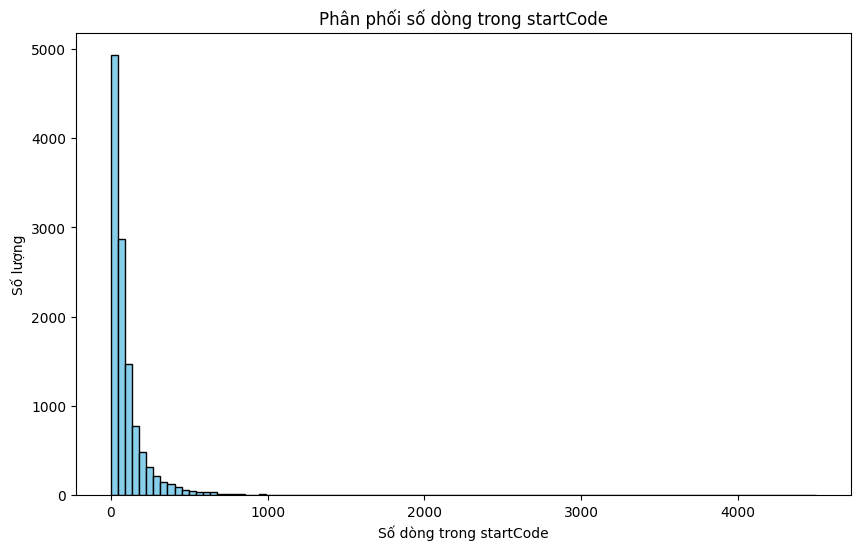

In [9]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
max_lines = data_target['startCode_lines'].max()
lineInBines = max_lines / 100
print(lineInBines)
plt.hist(data_target['startCode_lines'], bins=100, color='skyblue', edgecolor='black')
plt.xlabel('Số dòng trong startCode')
plt.ylabel('Số lượng')
plt.title('Phân phối số dòng trong startCode')
# plt.xlim(0, 2000)

plt.show()

In [1]:
import pandas as pd
data = pd.read_parquet('/drive2/phatnt/zTrans/data/data_method_level.parquet')

In [2]:
import re
import difflib
def find_changed_method_signatures(start_code, end_code):
    s = ""
    start_lines = start_code.splitlines()
    end_lines = end_code.splitlines()
    
    # Sử dụng difflib để so sánh và tìm sự thay đổi
    diff_obj = difflib.ndiff(start_lines, end_lines)
    changes = list(diff_obj)

    
    # Duyệt qua sự thay đổi và xác định các phương thức liên quan
    changed_methods = set()
    current_method = ""
    for line in range(len(changes)):
        s+=changes[line]
        s+='\n'
    return s
def check_is_a_method(line):
    access_modify = ['public','protected','private']
    # if any(modifier in line for modifier in access_modify):

def get_changes(code):
    lines = code.splitlines()
    methods = []
    current_method = []
    inside_method = False
    open_braces_count = 0

    for line in lines:
        # Strip leading and trailing whitespace from the line
        stripped_line = line.strip()

        if not inside_method:
            # Check if the line starts a method declaration
            if any(stripped_line.startswith(access_modifier) for access_modifier in ["public", "protected", "private"]):
                if "(" in stripped_line:
                    # Found the start of a method (potential multi-line declaration)
                    inside_method = True
                    open_braces_count = stripped_line.count("{") - stripped_line.count("}")
                    current_method.append(stripped_line)
        else:
            # Add the line to the current method
            current_method.append(stripped_line)
            open_braces_count += stripped_line.count("{")
            open_braces_count -= stripped_line.count("}")

            # If the open braces count is zero, the method has ended
            if '}' in stripped_line:
                if open_braces_count == 0:
                    methods.append("\n".join(current_method))
                    current_method = []
                    inside_method = False
            
    # Ensure any remaining method gets added (handles edge cases)
    if current_method:
        methods.append("\n".join(current_method))

    return methods

def extract_methods(code):
    lines = code.splitlines()
    methods = []
    current_method = []
    inside_method = False
    open_braces_count = 0

    for line in lines:
        # Xóa khoảng trắng ở đầu và cuối dòng
        stripped_line = line.strip()

        # Kiểm tra dòng bắt đầu của một phương thức
        if not inside_method and any(stripped_line.startswith(access_modifier) for access_modifier in ["public", "protected", "private"]):
            if '(' in stripped_line:
                # Bắt đầu ghi lại dòng vì đã tìm thấy từ khóa truy cập và dấu '('
                inside_method = True
                open_braces_count = stripped_line.count('{') - stripped_line.count('}')
                current_method.append(stripped_line)

        elif inside_method:
            # Đang ở trong một phương thức, thêm dòng vào và đếm dấu ngoặc
            current_method.append(stripped_line)
            open_braces_count += stripped_line.count('{')
            open_braces_count -= stripped_line.count('}')

            # Kiểm tra xem đã kết thúc phương thức chưa
            if open_braces_count == 0:
                # Kết thúc phương thức khi đã đóng đủ dấu ngoặc
                methods.append("\n".join(current_method))
                current_method = []
                inside_method = False

    lst_method_changes = []
    for change in methods:
        lst_line = change.split('\n')
        for line in lst_line:
            if line.startswith('+') or line.startswith('-'):
                lst_method_changes.append(change)
                break
    
    return lst_method_changes


# a = find_changed_method_signatures(data.iloc[1]['startCode'],data.iloc[1]['endCode'])


In [53]:

changes = extract_methods(a)

for i in changes:
    print(i)
    print('----->')

public void testAddSentenceMultipleTypes() {
-         final DSLMappingEntry mapping1 = context.mock(DSLMappingEntry.class, "mapping1");
?                                          --------

+         final DSLMappingEntry mapping1 = mock(DSLMappingEntry.class, "mapping1");
-         final DSLMappingEntry mapping2 = context.mock(DSLMappingEntry.class, "mapping2");
?                                          --------

+         final DSLMappingEntry mapping2 = mock(DSLMappingEntry.class, "mapping2");
-         final DSLMappingEntry mapping3 = context.mock(DSLMappingEntry.class, "mapping3");
?                                          --------

+         final DSLMappingEntry mapping3 = mock(DSLMappingEntry.class, "mapping3");
-         final DSLMappingEntry mapping4 = context.mock(DSLMappingEntry.class, "mapping4");
?                                          --------

+         final DSLMappingEntry mapping4 = mock(DSLMappingEntry.class, "mapping4");

-         context.checking( new Expect

In [3]:
def get_method_changes(row):
    # Lấy mã từ cột startCode và endCode
    start_code = row['startCode']
    end_code = row['endCode']
    
    # Sử dụng hàm find_changed_method_signatures
    changes = find_changed_method_signatures(start_code, end_code)
    
    # Sử dụng hàm extract_methods để lấy các phương thức đã thay đổi
    changed_methods = get_changes(changes)
    
    # Trả về phương thức đã thay đổi dưới dạng chuỗi (nếu cần)
    return "\n\n".join(changed_methods)
data['method_changes'] = data.apply(get_method_changes, axis=1)

In [3]:
print(data.iloc[2]['method_changes'])

public void testLockOnActiveWithModify2() throws Exception {
final PackageBuilder builder = new PackageBuilder();
builder.addPackageFromDrl( new InputStreamReader( getClass().getResourceAsStream( "test_LockOnActiveWithModify.drl" ) ) );
final Package pkg = builder.getPackage();

RuleBase ruleBase = getRuleBase();
ruleBase.addPackage( pkg );
ruleBase = SerializationHelper.serializeObject( ruleBase );
final StatefulSession session = ruleBase.newStatefulSession();
//        WorkingMemoryFileLogger logger = new WorkingMemoryFileLogger( session );
//        logger.setFileName( "conway" );

// populating working memory
final int size = 3;

Cell[][] cells = new Cell[size][];
FactHandle[][] handles = new FactHandle[size][];
for ( int row = 0; row < size; row++ ) {
cells[row] = new Cell[size];
handles[row] = new FactHandle[size];
for ( int col = 0; col < size; col++ ) {
cells[row][col] = new Cell( Cell.DEAD,
row,
col );
handles[row][col] = session.insert( cells[row][col] );
if ( row >= 1 && col

In [5]:
def split_method_changes(method_changes):
    lines = method_changes.splitlines()
    # Loại bỏ các dòng bắt đầu bằng '+' hoặc '?'
    method_before = "\n".join(
        line.replace('-', ' ', 1) if line.startswith('-') else line
        for line in lines
        if not (line.startswith('+') or line.startswith('?'))
    )
    # Nếu muốn tạo 'method_after', có thể áp dụng quy tắc riêng cho các dòng bắt đầu bằng '+'
    method_after = "\n".join(
        line.replace('+', ' ', 1) if line.startswith('+') else line
        for line in lines
        if not (line.startswith('-') or line.startswith('?'))
    )
    
    
    return method_before, method_after
data[['method_before', 'method_after']] = data['method_changes'].apply(
    lambda x: pd.Series(split_method_changes(x))
)

In [14]:
data.to_parquet('/drive2/phatnt/zTrans/data/data_method_level.parquet')

In [5]:
data.columns

Index(['id', 'fromLib', 'toLib', 'repoName', 'repoOwner', 'repoSplitName',
       'prevCommit', 'startCommit', 'endCommit', 'fileName', 'startCode',
       'endCode', 'diff', 'startCommitChanges', 'endCommitChanges',
       'startCode_cleaned', 'endCode_cleaned', 'diff_cleaned', 'total_added',
       'total_removed', 'total_position', 'detailed_changes', 'lib_percentage',
       'annotation_change', 'method_changes', 'method_signature_changes',
       'count_method_changes', 'count_method_signature_changes',
       'method_before', 'method_after'],
      dtype='object')

In [4]:
t = data[data['method_changes'] == '']
t

,id,fromLib,toLib,repoName,repoOwner,repoSplitName,prevCommit,startCommit,endCommit,fileName,...,total_position,detailed_changes,lib_percentage,annotation_change,method_changes,method_signature_changes,count_method_changes,count_method_signature_changes,method_before,method_after
87,93,ant:ant,org.apache.ant:ant,bobmcwhirter_drools,bobmcwhirter,drools,2ba5d35fb486c4a16b5b8b15fc247e8759bfa54f,92384035a8651b675c82689b24837eb8adb81d66,0df25aead759b3b542a685ac21a3a009bcd22fe9,drools-core/src/test/java/org/drools/reteoo/Jo...,...,4,"[{'added_count': 3, 'lib_changes': 3, 'line_ch...",0.008996,0.000000,,"[+ \tpublic void testUpdateSink() {, - pub...",10,20,,
132,156,ant:ant,org.apache.ant:ant,bobmcwhirter_drools,bobmcwhirter,drools,2ba5d35fb486c4a16b5b8b15fc247e8759bfa54f,92384035a8651b675c82689b24837eb8adb81d66,0df25aead759b3b542a685ac21a3a009bcd22fe9,drools-guvnor/src/main/java/org/drools/guvnor/...,...,2,"[{'added_count': 1, 'lib_changes': 0, 'line_ch...",0.000000,0.000000,,[],0,0,,
133,157,ant:ant,org.apache.ant:ant,bobmcwhirter_drools,bobmcwhirter,drools,2ba5d35fb486c4a16b5b8b15fc247e8759bfa54f,92384035a8651b675c82689b24837eb8adb81d66,0df25aead759b3b542a685ac21a3a009bcd22fe9,drools-guvnor/src/main/java/org/drools/guvnor/...,...,2,"[{'added_count': 1, 'lib_changes': 0, 'line_ch...",0.000000,0.000000,,[ isContainedInTheFollowingList=is contained ...,1,1,,
155,221,ant:ant,org.apache.ant:ant,teiid_teiid,teiid,teiid,b3fbe52b53c80fa0c956da71379a75c3751b39e8,48c337929319cc42e4b3a12397cb9fe39eb0c455,48c337929319cc42e4b3a12397cb9fe39eb0c455,api/src/main/java/org/teiid/translator/SourceS...,...,2,"[{'added_count': 0, 'lib_changes': 0, 'line_ch...",0.000000,0.000000,,[],0,0,,
213,283,ant:ant,org.apache.ant:ant,teiid_teiid,teiid,teiid,b3fbe52b53c80fa0c956da71379a75c3751b39e8,48c337929319cc42e4b3a12397cb9fe39eb0c455,48c337929319cc42e4b3a12397cb9fe39eb0c455,engine/src/main/javacc/org/teiid/query/parser/...,...,20,"[{'added_count': 1, 'lib_changes': 0, 'line_ch...",0.000000,0.003247,,[ \t\treturn new AllInGroupSymbol(normalizeId...,10,15,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57564,118438,redis.clients:jedis,org.springframework.boot:spring-boot-starter-r...,ghillert_botanic-ng,ghillert,botanic-ng,83aa265abe23e3c192e27842f7453dafc682dd01,5ddb96e564857b8f70de42a339d86dd33f7e5675,5ddb96e564857b8f70de42a339d86dd33f7e5675,src/main/java/com/hillert/botanic/controller/U...,...,2,"[{'added_count': 33, 'lib_changes': 15, 'line_...",0.208333,0.097222,,[+ \tpublic Image handleFileUpload(@RequestPar...,3,8,,
57576,118450,redis.clients:jedis,org.springframework.boot:spring-boot-starter-r...,ghillert_botanic-ng,ghillert,botanic-ng,83aa265abe23e3c192e27842f7453dafc682dd01,5ddb96e564857b8f70de42a339d86dd33f7e5675,5ddb96e564857b8f70de42a339d86dd33f7e5675,src/main/java/com/hillert/botanic/support/ISO8...,...,2,"[{'added_count': 2, 'lib_changes': 0, 'line_ch...",0.000000,0.000000,,"[+ \tpublic StringBuffer format(Date date, Str...",1,2,,
57613,118499,rhino:js,org.mozilla:rhino,happygiraffe_jslint4java,happygiraffe,jslint4java,50cdf72f19813b2fa7d7d1add88a609a221a440a,86a643ff774b2462c0032b1feaeafb1dd09d6266,86a643ff774b2462c0032b1feaeafb1dd09d6266,jslint4java/pom.xml,...,2,"[{'added_count': 2, 'lib_changes': 0, 'line_ch...",0.000000,0.000000,,[],0,0,,
57616,118507,rhino:js,org.mozilla:rhino,picocontainer_picocontainer,picocontainer,picocontainer,6c698a3b1043305f36cb7150053d3ce97bcef22d,d1544d25ba23121ddf43073f62f7ca7330991550,d1544d25ba23121ddf43073f62f7ca7330991550,script/script-jruby/src/java/org/picocontainer...,...,2,"[{'added_count': 2, 'lib_changes': 1, 'line_ch...",0.250000,0.000000,,[],0,0,,


In [16]:
data.drop(columns = ['count_method_changes','count_method_signature_changes','method_signature_changes'],inplace=True)

In [ ]:
data.iloc[1:100].to_csv('/drive2/phatnt/zTrans/data/data_method_level.csv',escapechar='\\', index=False)

In [13]:
def get_import_lines(code):
    ans = ''
    lst_code = code.split('\n')
    for line in lst_code:
        if 'package' in line:
            continue
        elif 'import' in line:
            ans+=line
            ans+='\n'
        elif 'class' in line:
            return ans
    
    return ans
data['import_before'] = data['startCode'].apply(lambda x: get_import_lines(x))
data['import_after'] = data['endCode'].apply(lambda x: get_import_lines(x))
data

,id,fromLib,toLib,repoName,repoOwner,repoSplitName,prevCommit,startCommit,endCommit,fileName,...,lib_percentage,annotation_change,method_changes,method_signature_changes,count_method_changes,count_method_signature_changes,method_before,method_after,import_before,import_after
0,3,ant:ant,org.apache.ant:ant,bobmcwhirter_drools,bobmcwhirter,drools,2ba5d35fb486c4a16b5b8b15fc247e8759bfa54f,92384035a8651b675c82689b24837eb8adb81d66,0df25aead759b3b542a685ac21a3a009bcd22fe9,drools-compiler/src/main/java/org/drools/rule/...,...,0.000000,0.000000,private final Pattern lineBreakFinder = Patter...,[ private void rewriteModify(final RuleBu...,1,1,private final Pattern lineBreakFinder = Patter...,private final Pattern lineBreakFinder = Patter...,import java.util.Arrays;\nimport java.util.Col...,import java.util.Arrays;\nimport java.util.Col...
1,4,ant:ant,org.apache.ant:ant,bobmcwhirter_drools,bobmcwhirter,drools,2ba5d35fb486c4a16b5b8b15fc247e8759bfa54f,92384035a8651b675c82689b24837eb8adb81d66,0df25aead759b3b542a685ac21a3a009bcd22fe9,drools-compiler/src/test/java/org/drools/guvno...,...,0.096774,0.000000,protected void setUp() throws Exception {\nsup...,[ public void testAddSentenceMultipleType...,1,1,protected void setUp() throws Exception {\nsup...,protected void setUp() throws Exception {\nsup...,import junit.framework.TestCase;\nimport org.d...,import junit.framework.TestCase;\nimport org.d...
4,7,ant:ant,org.apache.ant:ant,bobmcwhirter_drools,bobmcwhirter,drools,2ba5d35fb486c4a16b5b8b15fc247e8759bfa54f,92384035a8651b675c82689b24837eb8adb81d66,0df25aead759b3b542a685ac21a3a009bcd22fe9,drools-compiler/src/test/java/org/drools/integ...,...,0.000000,0.000000,protected RuleBase getRuleBase() throws Except...,[ public void testLockOnActiveWithModify2...,2,2,protected RuleBase getRuleBase() throws Except...,protected RuleBase getRuleBase() throws Except...,import java.io.IOException;\nimport java.io.In...,import java.io.IOException;\nimport java.io.In...
6,9,ant:ant,org.apache.ant:ant,bobmcwhirter_drools,bobmcwhirter,drools,2ba5d35fb486c4a16b5b8b15fc247e8759bfa54f,92384035a8651b675c82689b24837eb8adb81d66,0df25aead759b3b542a685ac21a3a009bcd22fe9,drools-compiler/src/test/java/org/drools/integ...,...,0.227273,0.000000,protected RuleBase getRuleBase() throws Except...,[ public void testAddRemoveListeners() th...,6,6,protected RuleBase getRuleBase() throws Except...,protected RuleBase getRuleBase() throws Except...,import java.io.IOException;\nimport java.io.In...,import static org.mockito.Matchers.any;\nimpor...
7,10,ant:ant,org.apache.ant:ant,bobmcwhirter_drools,bobmcwhirter,drools,2ba5d35fb486c4a16b5b8b15fc247e8759bfa54f,92384035a8651b675c82689b24837eb8adb81d66,0df25aead759b3b542a685ac21a3a009bcd22fe9,drools-compiler/src/test/java/org/drools/integ...,...,0.000000,0.000000,public static <T> T serializeObject(T obj) thr...,[ public static boolean areByteArraysEqua...,2,2,public static <T> T serializeObject(T obj) thr...,public static <T> T serializeObject(T obj) thr...,import java.io.ByteArrayInputStream;\nimport j...,import java.io.ByteArrayInputStream;\nimport j...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57638,118538,ru.yandex.qatools.properties:properties-loader,ru.qatools.commons:properties,yandex-qatools_hamcrest-pojo-matcher-generator,yandex-qatools,hamcrest-pojo-matcher-generator,13ac1e25cc715b6855890070099a3cdbea36cf56,cc7a474d3ea53164d28b4a1b23c25989982e7d03,cc7a474d3ea53164d28b4a1b23c25989982e7d03,feature-matcher-generator/src/test/java/ru/yan...,...,0.200000,0.100000,public void shouldHandleEmptyAnnotationsList()...,[ public void shouldHandleEmptyAnnotation...,2,2,public void shouldHandleEmptyAnnotationsList()...,public void shouldHandleEmptyAnnotationsList()...,import org.junit.Test;\nimport org.junit.runne...,import org.junit.Test;\nimport org.junit.runne...
57639,118539,ru.yandex.qatools.properties:properties-loader,ru.qatools.commons:properties,yandex-qatools_hamcrest-pojo-matcher-gener